In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader


In [2]:

from torchvision.transforms import v2



In [3]:

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=(0.85, 1.0), antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)
test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
    ])
)

# split the training data into training and validation
training_data, validation_data = torch.utils.data.random_split(training_data, [.8, .2], generator=torch.Generator().manual_seed(42))
batch_size = 128

# Create the dataloaders

train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              pin_memory=True,
                              shuffle=True,
                              num_workers=4)
validation_dataloader = DataLoader(validation_data,
                                   batch_size=batch_size,
                                   pin_memory=True,  # copy the data to the GPU
                                   shuffle=False,
                                   num_workers=4)  # number of subprocesses to use for data loading




/home/adrianhurtado/anaconda3/envs/ai-training/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


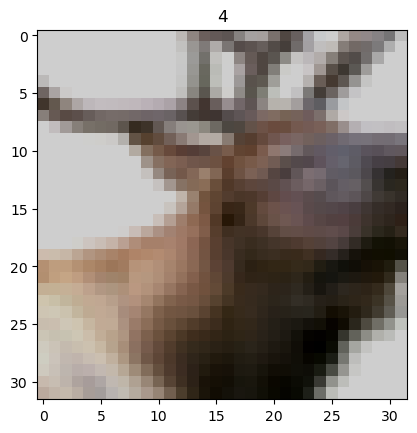

In [4]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].permute(1, 2, 0));
plt.title(Y[0].item());
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def preprocess(X, Y):
    # CIFAR-10 is *color*
    return X.view(-1, 3, 32, 32).to(device), Y.to(device)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
validation_dataloader = WrappedDataLoader(validation_dataloader, preprocess)

In [7]:
from torch import nn


class Downsampler(nn.Module):
    # down sampler downsamples the channels.  
    # since it's defined with kernel_size = stride, this will reduce 
    # the size of the image by stride times in each dimension.
    # This is a simple way to downsample the image.
    # Think of max pooling as a more sophisticated way to downsample the image.

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=stride,
            stride=stride,
        )

    def forward(self, inputs):
        return self.downsample(self.norm(inputs))


class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:
    start with an input with a 7 by 7 kernel, however with same padding it will not change the size of the image.
    Then we apply a normalization layer, and follow with 4 filters, aka patches,per channel.
    
    """

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()
        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                               groups=in_channels,
                               kernel_size=[7, 7],
                               padding='same')

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                               out_channels=4 * in_channels,
                               kernel_size=1)
        # Then we do the unrolling of the patches, and apply a non-linear activation function.

        self.conv3 = nn.Conv2d(in_channels=4 * in_channels,
                               out_channels=in_channels,
                               kernel_size=1
                               )

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = torch.nn.functional.gelu(x)
        # I add another non-linear activation layer here.
        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)
        
        x = torch.nn.functional.gelu(x)
        # I add another non-linear activation layer here.
        
        x = self.norm(x)
        # and followed with a normalization layer.

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):

    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()
        # our first example is set with 64,4,2 meaning 64 initial filters, 4 stages, 2 blocks per stage

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                              out_channels=n_initial_filters,
                              kernel_size=1,
                              stride=1)
        # Here is the initial convolution which takes our 32 x 32 image with 3 channels and 
        # converts it to 64 channels with a 1x1 convolution

        # In other words, this stem is a patching operation that converts the input image into a set of patches.
        # 3 to 64.  maybe here it makes sense to make n_intial_filters = 3 * filter_per_channel.. say 32

        current_shape = [32, 32]
        self.norm1 = nn.LayerNorm([n_initial_filters, *current_shape])
        # self.norm1 = WrappedLayerNorm()
        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2 * current_n_filters,
                    shape=current_shape,
                )
                )
                # Double the number of filters:
                current_n_filters = 2 * current_n_filters
                # Cut the shape in half:
                current_shape = [cs // 2 for cs in current_shape]
                # here w eare doing a downsampling operation, which is a patching operation.
                # We record the current shape

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x


In [8]:
#model = Classifier(64, 4, 2)
#model.cuda()
# The first test will be to set the initial filter to a multiple of . Actually, Why don't I just convert the image to a 1 channel if color should not matter for these images.  I can then normalize the image as well.  
# 3 stages 
# 2 blocks per stage
model = Classifier(64, 3, 3)
model.cuda()


Classifier(
  (stem): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (norm1): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (layers): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=64)
      (norm): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNextBlock(
      (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=64)
      (norm): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
      (conv2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ConvNextBlock(
      (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=64)
      (norm): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=

In [9]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode 
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calcualting the gradients
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, Y).item()
            correct += torch.sum(torch.argmax(pred, dim=1) == Y).item()
            val_bar.update()
    loss /= num_batches
    correct /= (size * batch_size)
    accuracy = 100 * correct
    return accuracy, loss

In [10]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    # Set the model to training mode
    model.train()
    for batch, (X, Y) in enumerate(dataloader):
        pred = model(X)
        l = loss_fn(pred, Y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        progress_bar.update()


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [12]:
from tqdm import tqdm

In [13]:
epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(validation_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(validation_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Epoch 0: training loss: 1.636, accuracy: 38.558


Validate Epoch 0: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 0: validation loss: 1.636, accuracy: 37.599


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 1: training loss: 1.279, accuracy: 54.203


Validate Epoch 1: 100%|██████████| 79/79 [00:06<00:00, 11.60it/s]


Epoch 1: validation loss: 1.306, accuracy: 52.561


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Epoch 2: training loss: 1.064, accuracy: 62.026


Validate Epoch 2: 100%|██████████| 79/79 [00:06<00:00, 11.58it/s]


Epoch 2: validation loss: 1.102, accuracy: 59.424


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 3: training loss: 0.847, accuracy: 70.040


Validate Epoch 3: 100%|██████████| 79/79 [00:06<00:00, 11.60it/s]


Epoch 3: validation loss: 0.912, accuracy: 67.830


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 4: training loss: 0.718, accuracy: 74.626


Validate Epoch 4: 100%|██████████| 79/79 [00:06<00:00, 11.59it/s]


Epoch 4: validation loss: 0.813, accuracy: 70.609


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 5: training loss: 0.587, accuracy: 79.495


Validate Epoch 5: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 5: validation loss: 0.700, accuracy: 74.743


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Epoch 6: training loss: 0.522, accuracy: 81.614


Validate Epoch 6: 100%|██████████| 79/79 [00:06<00:00, 11.52it/s]


Epoch 6: validation loss: 0.656, accuracy: 75.821


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:26<00:00, 11.67it/s]


Epoch 7: training loss: 0.428, accuracy: 85.219


Validate Epoch 7: 100%|██████████| 79/79 [00:06<00:00, 11.47it/s]


Epoch 7: validation loss: 0.606, accuracy: 77.522


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Epoch 8: training loss: 0.380, accuracy: 86.384


Validate Epoch 8: 100%|██████████| 79/79 [00:06<00:00, 11.53it/s]


Epoch 8: validation loss: 0.594, accuracy: 78.817


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 9: training loss: 0.336, accuracy: 88.356


Validate Epoch 9: 100%|██████████| 79/79 [00:06<00:00, 11.52it/s]


Epoch 9: validation loss: 0.546, accuracy: 80.479


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Epoch 10: training loss: 0.298, accuracy: 89.624


Validate Epoch 10: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


Epoch 10: validation loss: 0.576, accuracy: 80.133


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Epoch 11: training loss: 0.272, accuracy: 90.418


Validate Epoch 11: 100%|██████████| 79/79 [00:06<00:00, 11.56it/s]


Epoch 11: validation loss: 0.585, accuracy: 80.063


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 12: training loss: 0.250, accuracy: 91.029


Validate Epoch 12: 100%|██████████| 79/79 [00:06<00:00, 11.51it/s]


Epoch 12: validation loss: 0.585, accuracy: 79.974


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 13: training loss: 0.211, accuracy: 92.442


Validate Epoch 13: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


Epoch 13: validation loss: 0.587, accuracy: 80.558


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 14: training loss: 0.232, accuracy: 91.678


Validate Epoch 14: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 14: validation loss: 0.591, accuracy: 80.133


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 15: training loss: 0.190, accuracy: 93.231


Validate Epoch 15: 100%|██████████| 79/79 [00:06<00:00, 11.53it/s]


Epoch 15: validation loss: 0.582, accuracy: 80.983


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Epoch 16: training loss: 0.142, accuracy: 95.233


Validate Epoch 16: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 16: validation loss: 0.525, accuracy: 82.595


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 17: training loss: 0.142, accuracy: 95.065


Validate Epoch 17: 100%|██████████| 79/79 [00:06<00:00, 11.50it/s]


Epoch 17: validation loss: 0.571, accuracy: 81.705


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 18: training loss: 0.138, accuracy: 95.190


Validate Epoch 18: 100%|██████████| 79/79 [00:06<00:00, 11.50it/s]


Epoch 18: validation loss: 0.582, accuracy: 81.547


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 19: training loss: 0.137, accuracy: 95.105


Validate Epoch 19: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


Epoch 19: validation loss: 0.605, accuracy: 81.942


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Epoch 20: training loss: 0.106, accuracy: 96.169


Validate Epoch 20: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


Epoch 20: validation loss: 0.575, accuracy: 82.704


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 21: training loss: 0.102, accuracy: 96.438


Validate Epoch 21: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


Epoch 21: validation loss: 0.555, accuracy: 83.139


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 22: training loss: 0.126, accuracy: 95.475


Validate Epoch 22: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 22: validation loss: 0.628, accuracy: 81.626


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


Epoch 23: training loss: 0.093, accuracy: 96.693


Validate Epoch 23: 100%|██████████| 79/79 [00:06<00:00, 11.53it/s]


Epoch 23: validation loss: 0.581, accuracy: 82.852


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 24: training loss: 0.087, accuracy: 96.795


Validate Epoch 24: 100%|██████████| 79/79 [00:06<00:00, 11.53it/s]


Epoch 24: validation loss: 0.567, accuracy: 82.684


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 25: training loss: 0.105, accuracy: 96.326


Validate Epoch 25: 100%|██████████| 79/79 [00:06<00:00, 11.52it/s]


Epoch 25: validation loss: 0.606, accuracy: 82.427


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 26: training loss: 0.105, accuracy: 96.139


Validate Epoch 26: 100%|██████████| 79/79 [00:06<00:00, 11.53it/s]


Epoch 26: validation loss: 0.634, accuracy: 82.269


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:26<00:00, 11.70it/s]


Epoch 27: training loss: 0.094, accuracy: 96.618


Validate Epoch 27: 100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


Epoch 27: validation loss: 0.620, accuracy: 82.526


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 28: training loss: 0.083, accuracy: 97.007


Validate Epoch 28: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 28: validation loss: 0.617, accuracy: 82.753


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:26<00:00, 11.71it/s]


Epoch 29: training loss: 0.090, accuracy: 96.738


Validate Epoch 29: 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]

Epoch 29: validation loss: 0.642, accuracy: 82.476


In [14]:
!nvidia-smi


Thu Feb 22 17:12:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   84C    P0              27W /  45W |   3246MiB /  4096MiB |     52%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}